# Examples of applications

Let's look at some concrete examples of Network Machine Learning tasks, along with the techniques that can tackle them which we'll explore in this book.

## Finding working groups in your company
Community detection is a major focus in network science, and many techniques have been proposed to accomplish this. We'll primarily use Adjacency Spectral Embedding or Laplacian Spectral Embedding (6.3, Spectral Embedding Methods, and throughout the book) combined with K-Means Clustering or a Gaussian Mixture Model to reconstruct labels.

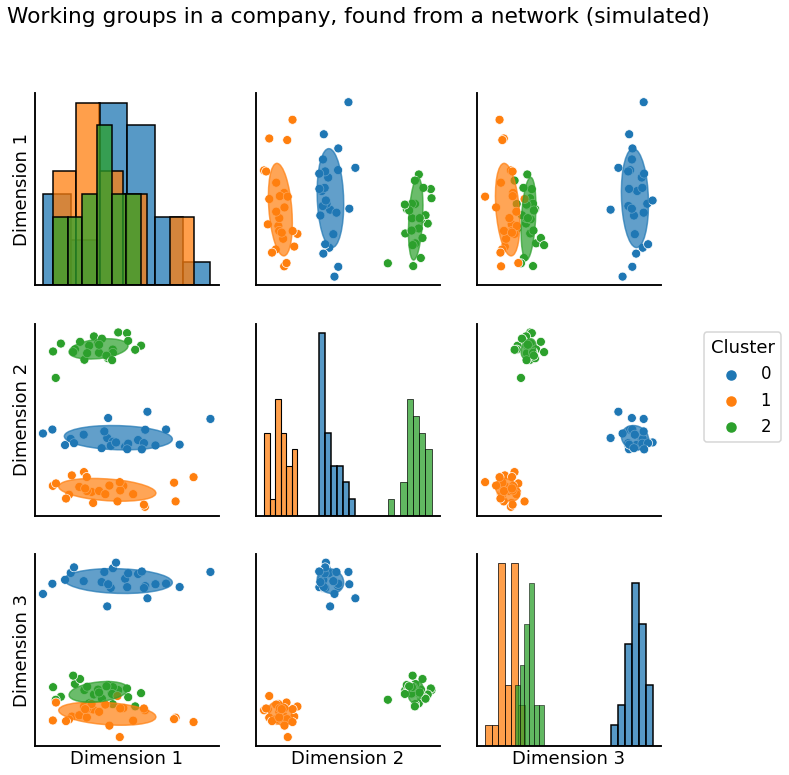

In [1]:
from graspologic.simulations import sbm
from graspologic.embed import AdjacencySpectralEmbed as ASE
import numpy as np
from graspologic.plot import pairplot_with_gmm
from sklearn.mixture import GaussianMixture
from graphbook_code import cmaps

# Make network and embed
B = np.array([[0.8, 0.1, .1], 
              [0.1, 0.8, .1],
              [0.1, 0.1, .8]])
n = [25, 25, 25]
A, labels = sbm(n, p=B, return_labels=True)
X = ASE(n_components=3).fit_transform(A)

# plot
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(X)
graph = pairplot_with_gmm(X, gmm, cluster_palette=cmaps["qualitative"],  label_palette=cmaps["qualitative"], title="Working groups in a company, found from a network (simulated)")

## Finding the hemisphere a new neuron you haven't seen before belongs to
This is called out-of-sample embedding, and is typically done by using the results from a previous embedding along with a trick involving the moore-penrose pseudoinverse (8.5, Out-of-Sample Embedding)

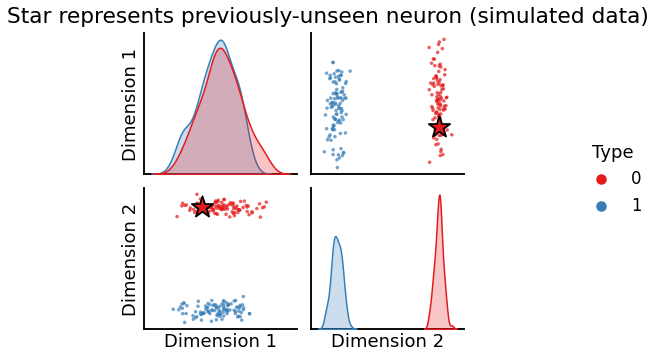

In [2]:
from graspologic.utils import remove_vertices
from graspologic.plot import pairplot
import pandas as pd
import seaborn as sns

# Generate parameters
nodes_per_community = 100
P = np.array([[0.8, 0.2],
              [0.2, 0.8]])

# Generate an undirected Stochastic Block Model (SBM)
undirected, labels_ = sbm(2*[nodes_per_community], P, return_labels=True)
labels = list(labels_)

# Grab out-of-sample vertices
oos_idx = 0
oos_labels = labels.pop(oos_idx)
A, a = remove_vertices(undirected, indices=oos_idx, return_removed=True)

# Generate an embedding with ASE
ase = ASE(n_components=2)
X_hat_ase = ase.fit_transform(A)

# predicted latent positions
w_ase = ase.transform(a)

def plot_oos(X_hat, oos_vertices, labels, oos_labels, title):
    # Plot the in-sample latent positions
    plot = pairplot(X_hat, labels=labels, title=title)

    # generate an out-of-sample dataframe
    oos_vertices = np.atleast_2d(oos_vertices)
    data = {'Type': oos_labels,
          'Dimension 1': oos_vertices[:, 0],
          'Dimension 2': oos_vertices[:, 1]}
    oos_df = pd.DataFrame(data=data)

    # update plot with out-of-sample latent positions,
    # plotting out-of-sample latent positions as stars
    plot.data = oos_df
    plot.hue_vals = oos_df["Type"]
    plot.map_offdiag(sns.scatterplot, s=500,
                     marker="*", edgecolor="black")
    plot.tight_layout()
    return plot

# Plot all latent positions
title = "Star represents previously-unseen neuron (simulated data)"
plot_oos(X_hat_ase, w_ase, labels=labels, oos_labels=[0], title=title);

## Using a subset of connecting flights to find the rest of them
This a problem called vertex nomination, where you have a network along with a few nodes that are interesting to you, and want to find the rest of the interesting nodes (8.4, Single-Network Vertex Nomination)

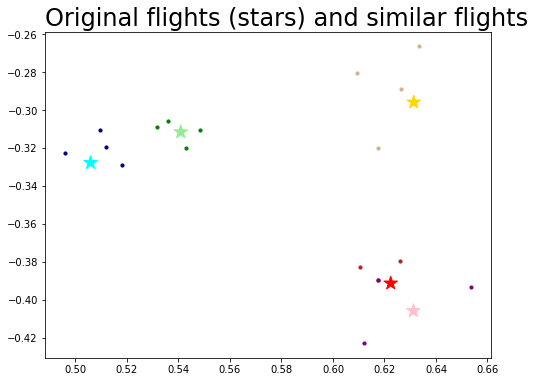

In [3]:
from graspologic.nominate import SpectralVertexNomination
import matplotlib.pyplot as plt

# construct network
n = 100
B = np.array([[0.5, 0.35, 0.2],
              [0.35, 0.6, 0.3],
              [0.2, 0.3, 0.65]])

# Create a network from and SBM, then embed
A, labels = sbm([n, n, n], p=B, return_labels=True)
ase = ASE()
X = ase.fit_transform(A)

# Let's say we know that the first five nodes belong to the first community.
# We'll say that those are our seed nodes.
seeds = np.ones(5)

# grab a set of seed nodes
memberships = labels.copy() + 1
mask = np.zeros(memberships.shape)
seed_idx = np.arange(len(seeds))
mask[seed_idx] = 1
memberships[~mask.astype(bool)] = 0

# find the latent positions for the seed nodes
seed_latents = X[memberships.astype(bool)]

# Choose the number of nominations we want for each seed node
svn = SpectralVertexNomination(n_neighbors=5)
svn.fit(A)

# get nominations and distances for each seed index
nominations, distances = svn.predict(seed_idx)

color = ['red', 'lightgreen', 'gold', 'cyan', 'pink']
seed_color = ['firebrick', 'green', 'tan', 'darkblue', 'purple']


fix, ax = plt.subplots(figsize=(8, 6))

for i, seed_group in enumerate(nominations.T):
    neighbors = X[seed_group]
    x, y = neighbors[:, 0], neighbors[:, 1]
    ax.scatter(x, y, c=seed_color[i], s=10)
    
ax.scatter(x=seed_latents[:, 0], y=seed_latents[:, 1], marker='*', s=200, c=color, alpha=1)
    
ax.set_title("Original flights (stars) and similar flights", loc="left", fontsize=24);

## Finding the working groups that were recently dissolved in your competitor's company
This is a problem called signal subgraph estimation, which we renamed to signal subnetwork estimation. The general idea is that you have two different networks, and you want to find the subset of nodes which carry the information about the differences between your networks. In this example, you have two snapshots of working relationships in a company: one before a working group was dissolved, and one after. Although there is always variation in working relationships between individuals, an entire working group being changed is a signal change in your network. We talk about this in 5.6, Network Models with Covariates, and then again in 10.2, Testing for Significant Edges, and 10.3, Testing for Significant Nodes.

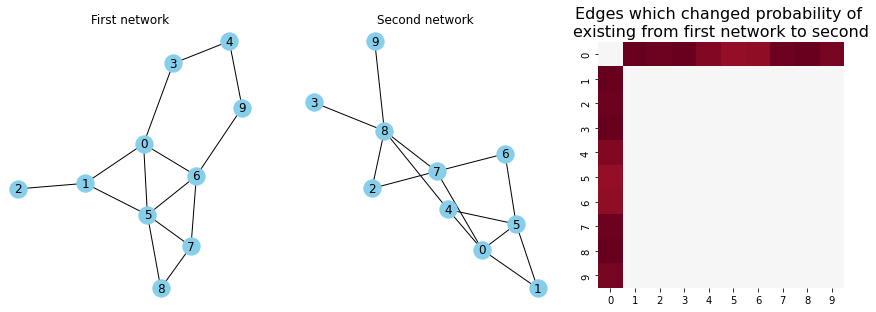

In [5]:
from graphbook_code import ier
import networkx as nx
from graspologic.plot import heatmap

n = 10
gen = np.random.default_rng(seed=42)
P_hum = gen.beta(size=n*n, a=3, b=8).reshape(n, n)
P_hum = (P_hum + P_hum.T)/2
P_hum = P_hum - np.diag(np.diag(P_hum))

E = np.zeros((n, n))
E[0, 1:] = 1
E[1:, 0] = 1
E = E.astype(bool)
P_ast = np.copy(P_hum)
P_ast[E] = np.sqrt(P_ast[E])  # probabilities for signal edges are higher in astronauts than humans

np.random.seed(5)
Ahum = ier(P_hum, loops=False, directed=False)
Aast = ier(P_ast, loops=False, directed=False)

Ghum = nx.from_numpy_array(Ahum)
Gast = nx.from_numpy_array(Aast)

# plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plot_dict = dict(with_labels=True, node_color="skyblue")
nx.draw(Ghum, ax=axs[0], **plot_dict)
nx.draw(Gast, ax=axs[1], **plot_dict)
edge_prob_plot = heatmap(P_ast-P_hum, ax=axs[2], cbar=False, xticklabels=True, yticklabels=True)
edge_prob_plot.set_title("Edges which changed probability of \nexisting from first network to second", fontsize=16)
axs[0].set_title("First network")
axs[1].set_title("Second network");

## Using extra data like house size and price to find more precise groups of houses in a house buying/selling network
This is called joint representation learning, and we talk about it extensively in 6.8. The idea is that you have the topological information of your network in the form of its nodes and edges -- for example, a buying/selling network for houses -- and you also have extra data for each house, like its size, number of bathrooms, etc. The nodes and edges contain some of the information about the network, but not all, and the extra data contains different information. The idea is that you can combine both the nodes and edges and the extra data to make your inferences better.

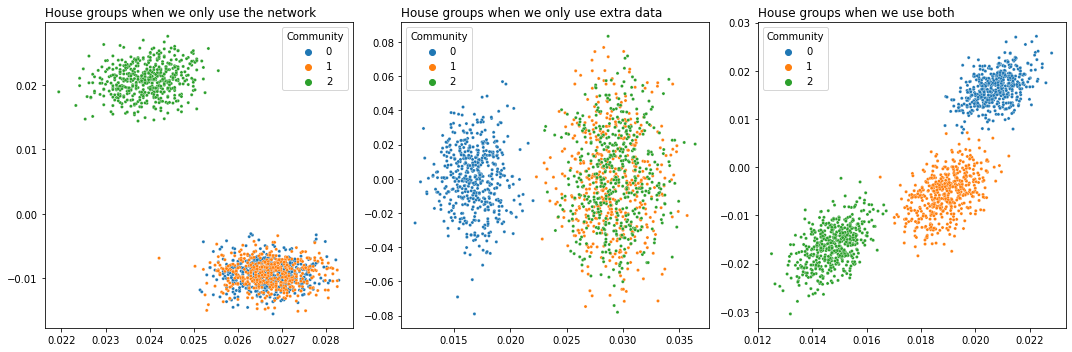

In [6]:
from scipy.stats import beta
from graspologic.embed import CovariateAssistedEmbed as CASC
from graspologic.embed import LaplacianSpectralEmbed as LSE
from sklearn.utils.extmath import randomized_svd
from graphbook_code import plot_latents

# Start with some simple parameters
N = 1500  # Total number of nodes
n = N // 3  # Nodes per community
p, q = .3, .15
B = np.array([[.3, .3, .15],
              [.3, .3, .15],
              [.15, .15, .3]])  # Our block probability matrix

# Make our Stochastic Block Model
A, labels = sbm([n, n, n], B, return_labels = True)

def make_community(a, b, n=500):
    return beta.rvs(a, b, size=(n, 30))

def gen_covariates():
    c1 = make_community(2, 5)
    c2 = make_community(2, 2)
    c3 = make_community(2, 2)

    covariates = np.vstack((c1, c2, c3))
    return covariates
    

def embed(matrix, *, dimension):
    latents, _, _ = randomized_svd(matrix, n_components=dimension)
    return latents

# Generate a covariate matrix
Y = gen_covariates()
casc = CASC(n_components=2)
X = casc.fit_transform(A, Y)
X_A = LSE(n_components=2).fit_transform(A)
X_Y = embed(Y, dimension=2)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15,5))
plot_latents(X_A, title="House groups when we only use the network", 
             labels=labels, ax=axs[0])
plot_latents(X_Y, title="House groups when we only use extra data", 
             labels=labels, ax=axs[1]);
plot_latents(X, title="House groups when we use both", 
             labels=labels, ax=axs[2])

plt.tight_layout()

## Representing sets of mouse brain networks as a single point in space to compare their overall similarities and differences
To do this, you'd jointly embed all of your brain networks at once using an Omnibus Embedding, then you'd create a pairwise difference matrix for each embedding. You'd then embed the pairwise distance matrix using Classic Multidimensional Scaling. This isn't discussed at length in this book, but is mentioned in 4.2.4, Bag of Networks. You can look up Multiscale Comparative Connectomics by Gopalakrishnan et al., 2021 to see how to do this in more depth.

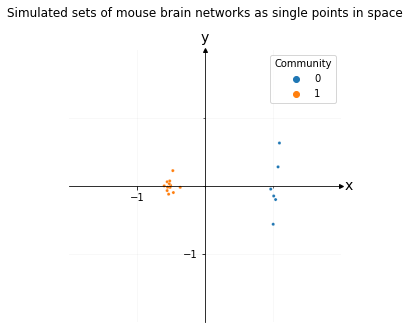

In [7]:
from graspologic.embed import OmnibusEmbed as OMNI
from graspologic.embed import ClassicalMDS
from graphbook_code import draw_cartesian

def make_network(*probs, n=100, return_labels=False):
    pa, pb, pc, pd = probs
    P = np.array([[pa, pb], 
                  [pc, pd]])
    
    return sbm([n, n], P, return_labels=return_labels)

n = 100
p1, p2, p3 = .12, .06, .03

first_group = []
for _ in range(6):
    network = make_network(p1, p3, p3, p1)
    first_group.append(network)
    
second_group = []
for _ in range(12):
    network = make_network(p2, p3, p3, p2)
    second_group.append(network)

# Find a euclidean location for the nodes of all of our networks
omni = OMNI(n_components=2)
omni_embedding = omni.fit_transform(first_group + second_group)

# embed each network representation into a 2-dimensional space
cmds = ClassicalMDS(2)
cmds_embedding = cmds.fit_transform(omni_embedding)

# Find and normalize the dissimilarity matrix
distance_matrix = cmds.dissimilarity_matrix_ / np.max(cmds.dissimilarity_matrix_)

labels = [0]*6 + [1]*12
ax = draw_cartesian(xrange=(-1, 1), yrange=(-1, 1))
plot = plot_latents(cmds_embedding, ax=ax, labels=labels)
plot.set_title("Simulated sets of mouse brain networks as single points in space", y=1.1);

## Figuring out which users match between the facebook social network and the twitter social network, without knowing their names
This problem has been studied extensively, and is called graph matching. You can find an in-depth discussion of it in 9.3, Graph Matching.

Text(0.5, 1.1, 'Node correspondence between \ntwitter and facebook network')

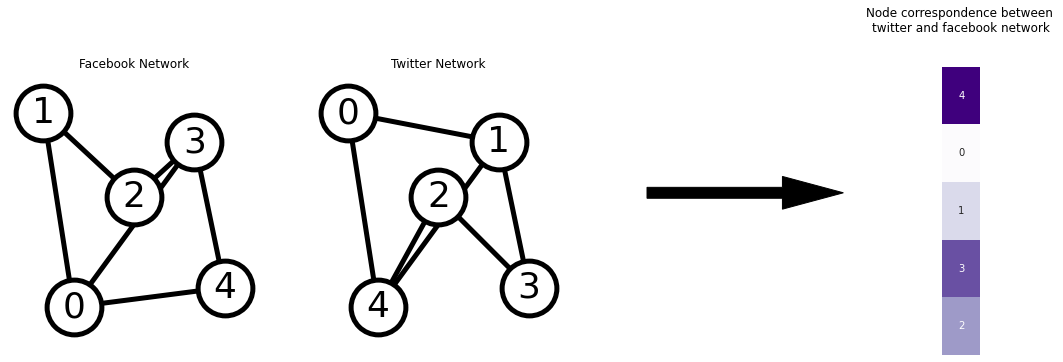

In [8]:
from graspologic.simulations import er_np
from graspologic.match import GraphMatch
import networkx as nx
from graphbook_code import cmaps

def rm_ticks(ax, x=False, y=False, **kwargs):
    if x is not None:
        ax.axes.xaxis.set_visible(x)
    if y is not None:
        ax.axes.yaxis.set_visible(y)
    sns.despine(ax=ax, **kwargs)

n = 5
p = 0.5

# draw a network, then shuffle
A = er_np(n=n, p=p)
node_shuffle_input = np.random.permutation(n)
B = A[node_shuffle_input][:, node_shuffle_input]

gmp = GraphMatch()
gmp = gmp.fit(A,B)
B_ = B[gmp.perm_inds_][:, gmp.perm_inds_]

A_nx = nx.from_numpy_matrix(A)
B_nx = nx.from_numpy_matrix(B)

# explicitly set positions
pos = {0: (0, 0), 1: (-1, 0.3), 2: (2, 0.17), 3: (4, 0.255), 4: (5, 0.03)}

options = {
    "font_size": 36,
    "node_size": 3000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
nx.draw_networkx(A_nx, pos, ax=axs[0], **options)
# Set margins for the axes so that nodes aren't clipped
axs[0].margins(0.20)
axs[0].set_title("Facebook Network")
axs[0].axis('off')

pos_b = {node_shuffle_input[i]: loc for i, loc in pos.items()}
# pos_b = {2: (0, 0), 1: (-1, 0.3), 4: (2, 0.17), 3: (4, 0.255), 0: (5, 0.03)}
nx.draw_networkx(B_nx, pos_b, ax=axs[1], **options)
axs[1].margins(0.20)
axs[1].set_title("Twitter Network")
axs[1].axis('off')

# add second arrow
arrow_ax = fig.add_axes([1, .5, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add second arrow
match_ax = fig.add_axes([1.2, 0.1, .5, .8])
rm_ticks(match_ax, left=True, bottom=True)

match_ax = sns.heatmap(gmp.perm_inds_[:, None], cmap=cmaps["sequential"], ax=match_ax, cbar=False, 
                 xticklabels=1, yticklabels=1, annot=True)
match_ax.set_aspect(1.5)
match_ax.set_title("Node correspondence between \ntwitter and facebook network", y=1.1)

## Estimating the day that the Federal Reserve tightened rates using a timeseries of stock market networks
This is called timeseries anomaly detection, and is used when you have a timeseries of the same network, and you're trying to figure out when the probability distribution it was drawn from changed (10.1, Anomaly Detection for Timeseries of Networks)

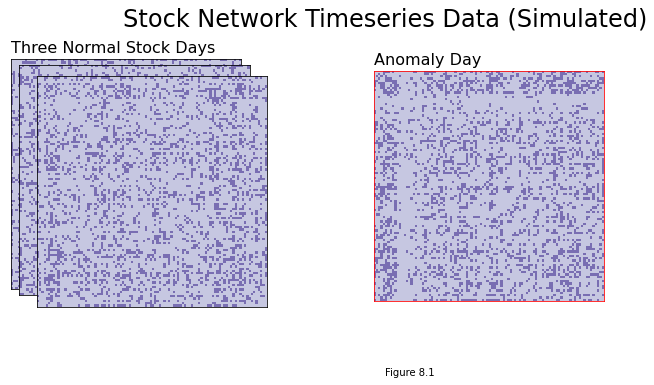

In [9]:
import matplotlib.pyplot as plt
from graphbook_code import heatmap, cmaps
import seaborn as sns
import numpy as np
from graspologic.simulations import rdpg


def gen_timepoint(X, perturbed=False, n_perturbed=20):
    if perturbed:
        X = np.squeeze(X)
        baseline = np.array([1, -1, 0])
        delta = np.repeat(baseline, (n_perturbed//2, 
                                     n_perturbed//2, 
                                     nodes-n_perturbed))
        X += (delta * .15)
    if X.ndim == 1:
        X = X[:, np.newaxis]
    A = rdpg(X)
    return A
    

time_points = 4
nodes = 100
X = np.random.uniform(.2, .8, size=nodes)

# normal time points
networks = []
for time in range(time_points - 1):
    A = gen_timepoint(X)
    networks.append(A)

# perturbed time point
A = gen_timepoint(X, perturbed=True)
networks.insert(2, A)
    
networks = np.array(networks)

fig = plt.figure();

# adjacency matrices
perturbed_point = 2
for i in range(time_points):
    if i != 2:
        ax = fig.add_axes([.02*i, -.02*i, .8, .8])
    else:
        ax = fig.add_axes([.02*i+.8, -.02*i, .8, .8])
    ax = heatmap(networks[i], ax=ax, cbar=False)
    if i == 0:
        ax.set_title("Three Normal Stock Days", loc="left", fontsize=16)
    if i == 2:
        ax.set_title("Anomaly Day", loc="left", fontsize=16)
        for spine in ax.spines.values():
            spine.set_edgecolor("red")
    rm_ticks(ax, top=False, right=False)
    
plt.figtext(1, -.3, "Figure 8.1")
fig.suptitle("Stock Network Timeseries Data (Simulated)", fontsize=24, x=1);

## Figuring out if two estimated brain networks come from the same person
This is hypothesis testing on networks, where you're trying to figure out if two networks were drawn from the same probability distribution (9.1, Two-Sample Hypothesis Testing).

Text(0, 0.5, 'frequency')

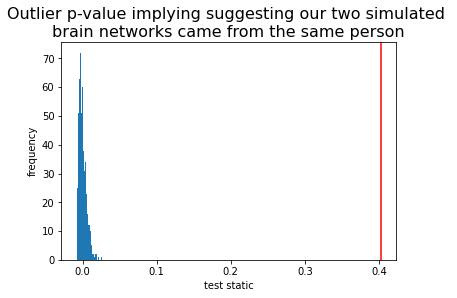

In [10]:
from graspologic.inference import latent_distribution_test
from graspologic.utils import symmetrize

n_components = 4 # the number of embedding dimensions for ASE
P = np.array([[0.9, 0.11, 0.13, 0.2],
              [0, 0.7, 0.1, 0.1],
              [0, 0, 0.8, 0.1],
              [0, 0, 0, 0.85]])

P = symmetrize(P)
csize = [32] * 4
A = sbm(csize, P)
X = ASE(n_components=n_components).fit_transform(A)

# generate networks from latent positions
A1 = rdpg(X,
          loops=False,
          rescale=False,
          directed=False)
A2 = rdpg(X,
          loops=False,
          rescale=False,
          directed=False)

ldt_dcorr = latent_distribution_test(A1, A2, test="dcorr", metric="euclidean", n_bootstraps=1000)

fig, ax = plt.subplots()
ax.hist(ldt_dcorr[2]['null_distribution'], 50)
ax.axvline(ldt_dcorr[1], color='r')
ax.set_title("Outlier p-value suggesting our two simulated \nbrain networks came from the same person".format(ldt_dcorr[0]), fontsize=16)
ax.set_xlabel("test static")
ax.set_ylabel("frequency")